# Setup

In [211]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import torch
from torch import distributions
from torch import nn
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [212]:
from project.models.ising import IsingModel
import project.networks.net as net

# Define Ising Model

CPU times: user 189 µs, sys: 0 ns, total: 189 µs
Wall time: 195 µs


3.2

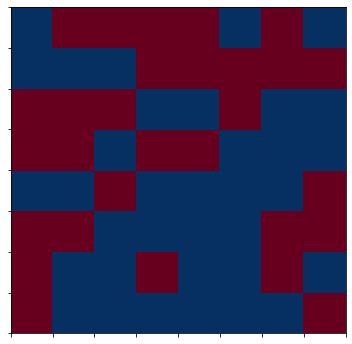

In [213]:
h = 0.0
J = 0.8
T = 1.0
N = 8

ising = IsingModel(h = h, J = J)
x0 = ising.init_coords(N)

ising.draw_config(x0)
%time ising.energy(x0) # energy of a given configuration 

## Create training set
We'd like to have a $m$ x $N$ matrix containing our training data where $m$ is the number of realizations of the system and $N$ is the number of features (i.e. the flattened dimensions of the system). For example, a training set with 1000 samples of the Ising Model for $N=8$ would be of size (1000, 64). 

In [214]:
num_samples = 2 # as done in Noe et al. for the biwell potential 
flattened_size = N**2

training_set = np.zeros((num_samples,flattened_size), dtype=np.float32)
for i in range(num_samples):
    training_set[i,:] = ising.init_coords(N).flatten() # generate random configuration 
training_set = torch.from_numpy(training_set) # convert to PyTorch tensor 

As an aside, note that although we flatten our configurations for training, the flattening procedure can easily be reversed via the `rehsape()` function: 

In [215]:
np.array(x0)

array([[ 1, -1, -1, -1, -1, -1, -1,  1],
       [ 1, -1, -1,  1, -1, -1,  1, -1],
       [ 1,  1, -1, -1, -1, -1,  1,  1],
       [-1, -1,  1, -1, -1, -1, -1,  1],
       [ 1,  1, -1,  1,  1, -1, -1, -1],
       [ 1,  1,  1, -1, -1,  1, -1, -1],
       [-1, -1, -1,  1,  1,  1,  1,  1],
       [-1,  1,  1,  1,  1, -1,  1, -1]])

In [216]:
np.array(x0).flatten().reshape((N,N))

array([[ 1, -1, -1, -1, -1, -1, -1,  1],
       [ 1, -1, -1,  1, -1, -1,  1, -1],
       [ 1,  1, -1, -1, -1, -1,  1,  1],
       [-1, -1,  1, -1, -1, -1, -1,  1],
       [ 1,  1, -1,  1,  1, -1, -1, -1],
       [ 1,  1,  1, -1, -1,  1, -1, -1],
       [-1, -1, -1,  1,  1,  1,  1,  1],
       [-1,  1,  1,  1,  1, -1,  1, -1]])

# Boltzmann generator
## Define network architecture 

In [217]:
nets = lambda: nn.Sequential(nn.Linear(N**2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, N**2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(N**2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, N**2)) # net t

first_mask = np.array(np.concatenate((np.ones(round(N**2/2)), np.zeros(round(N**2/2)))))
masks_np = np.stack((first_mask, np.flip(first_mask),first_mask,np.flip(first_mask),first_mask, np.flip(first_mask))) 
masks = torch.from_numpy(masks_np.astype(np.float32))

prior = distributions.MultivariateNormal(torch.zeros(N**2), torch.eye(N**2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
network = net.RealNVP(nets, nett, masks, prior, x0.shape)

In [218]:
# to-do
# 1) implement expectation calculations so we can calculate the loss for the neural net  
# 2) implement Boltzmann reweighting 
# 3) update architecture defined above to match that of Noe et al. 

## Train model 

In [221]:
optimizer = torch.optim.Adam([p for p in network.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(1000):    
    loss = network.loss(training_set)
    
    optimizer.zero_grad() # we need to set the gradients to zero before starting to do 
                          # backpropragation because PyTorch accumulates the gradients on 
                          # subsequent backward passes.
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

NameError: name 'loss_ml' is not defined

## Visualize results